In [1]:
from parser import parse_files
from createPopulation import createPopulation
from makespan import makespan
from avaliarPop import avaliarPop
from retornaMelhorSolucao import retornaMelhorSolucao
from selecionarPop import selecionarPop
from recombinacao import recombinacao
from mutacao import mutacao
from selecionarNovaGeracao import selecionarNovaGeracao


import time

[[1, 3, 2], [3, 2, 1], [2, 1, 3], [2, 3, 1], [3, 2, 1]]


In [2]:
POPULATION_SIZE = 100
## em segundos
TIME_LIMIT = 30
MUTATION_FACTOR = .01
CONVERGENCIA_ALGEBRICA = .3
TAXA_DA_PROXIMA_GERAÇÃO = .3
# Numero de elementos p/ o criterio de diferença
# ele compara o 0 e o 100 elemento e vê a diferença entre os dois, se ela for menor
# que o da convergencia algebrica ele para
CONVERGENCIA_ALGEBRICA_DIFERENÇA = 500

### Ler e parsear os dados

In [3]:
files_path = ['files/tai20_5.txt', 'files/tai20_10.txt', 'files/tai20_20.txt', 'files/tai50_5.txt', 'files/tai50_10.txt', 'files/tai50_20.txt', 'files/tai100_5.txt', 'files/tai100_10.txt', 'files/tai100_20.txt', 'files/tai200_10.txt']

In [4]:
instances_list = parse_files(files_path)
# o campo processing possui as instancias a serem calculadas
print(instances_list[0])
print(len(instances_list))

{'processing': [[54, 83, 15, 71, 77, 36, 53, 38, 27, 87, 76, 91, 14, 29, 12, 77, 32, 87, 68, 94], [79, 3, 11, 99, 56, 70, 99, 60, 5, 56, 3, 61, 73, 75, 47, 14, 21, 86, 5, 77], [16, 89, 49, 15, 89, 45, 60, 23, 57, 64, 7, 1, 63, 41, 63, 47, 26, 75, 77, 40], [66, 58, 31, 68, 78, 91, 13, 59, 49, 85, 85, 9, 39, 41, 56, 40, 54, 77, 51, 31], [58, 56, 20, 85, 53, 35, 53, 41, 69, 13, 86, 72, 8, 49, 47, 87, 58, 18, 68, 28]], 'number of jobs': 20, 'number of machines': 5, 'initial seed': 873654221, 'upper bound and lower bound': 1278}
10


### Inicializar o relatorio para cada arquivo
relatório é uma lista de dicionarios

Iniciar o laço de repetição para cada arquivo

In [5]:
from typing import List, Tuple
import itertools
import json
import random

''' Aplica o crossover entre os pais
    Vamos dividir os dois pais em três pedaços,
    Cada um desses pedaços seram recombinados
    para gerar novos filhos.
    Se os pedaços possuirem a mesma tarefa (job),
    um dos items repetidos sera substituido pelas
    tarefas restantes aleatoriamente
    Um par de pais gera n filhos 
'''
def crossover(par: Tuple[List[int], List[int]]):
  pai1, pai2 = par

  tamanho_de_cada_parte = len(pai1) // 3

  partes_pai1 = [pai1[i:i+tamanho_de_cada_parte] for i in range(0, len(pai1), tamanho_de_cada_parte)]
  partes_pai2 = [pai2[i:i+tamanho_de_cada_parte] for i in range(0, len(pai2), tamanho_de_cada_parte)]

  ## partes_pai um possui uma lista de listas, cada uma com 1/3 da tarefa
  ## ex: [[1, 2, 3], [4, 5, 6], [7, 8, 9]] para a entrada [1, 2, 3, 4, 5, 6, 7, 8, 9]
  res = []
    
  ## gera uma coninação unica entre os pedaços de cada pai
  all_combinations = list(itertools.combinations(partes_pai1 + partes_pai2, 3))
  for combination_tuple in all_combinations:
    temp = []
    for item_list in combination_tuple:
      temp += [*item_list]

    ## remove possiveis duplicatas
    ## savar como string para depois transaformar em set para eliminar possiveis repetições
    try:
      res.append(json.dumps(temp))
    except Exception as e:
      print(e)
      print(type(temp))
  unique_elements = [json.loads(x) for x in list(set(res))]

  ## como cada elemento pode possuir a mesma tarefa mais de uma vez, precisamos fazer com que esse processo seje unico
  possiveis_jobs = set(pai1)

  ## remove jobs duplicados
  novos_filhos = []

  for novo_filho in unique_elements:
    novo_filho_set = set(possiveis_jobs)
    elementos_repetidos = {}

    for job in novo_filho:
      elementos_repetidos[job] = 1 + elementos_repetidos.get(job, 0)

      if job in novo_filho_set:
        novo_filho_set.remove(job)

    for job_index in range(len(novo_filho)):
      if elementos_repetidos[novo_filho[job_index]] > 1:
        elementos_repetidos[novo_filho[job_index]] -= 1
        novo_filho[job_index] = random.choice(list(novo_filho_set))
        novo_filho_set.remove(novo_filho[job_index])

    novos_filhos.append(novo_filho)
  
  ## retira possiveis filhos duplicados
  json_item = [json.dumps(x) for x in novos_filhos]

  json_list_set = list(set(json_item))

  filhos_unicos = [json.loads(x) for x in json_list_set]
  
  return filhos_unicos

def recombinacao(populacaoSelecionada: List[Tuple[List[int], List[int]]]):
  return [crossover(par) for par in populacaoSelecionada]


In [6]:
report_list = []

print(report_list)
for instance_index in range(len(instances_list)):
    # Começa vazio em todos os casos
    melhoresSolucoes = []
    todasAsMelhoresSolucoes = []
    # Para cada instância executar todo o algoritmo 10 vezes

    for i in range(10):
        current_instance = instances_list[instance_index]
        melhorSolucao = {'solucao':[], 'aptidao': float('inf'), 'tempoFinal':0}
        startTime = time.time()

        number_of_jobs = current_instance['number of jobs']
        instancia = current_instance['processing']

        populacao = createPopulation(number_of_jobs, POPULATION_SIZE)
        geracao = 0
        ultimosResultados = []

        while True:
            geracao += 1
            if geracao % 1000 == 0:
                print(TIME_LIMIT)
                print(time.time() - startTime)
                print(TIME_LIMIT <= time.time() - startTime)
            if TIME_LIMIT <= time.time() - startTime:
                break

            # criar segundo criterio de parada
            criterioParada2 = False
            if len(ultimosResultados) > CONVERGENCIA_ALGEBRICA_DIFERENÇA and abs(ultimosResultados.pop(0) - ultimosResultados[len(ultimosResultados) - 1]) < CONVERGENCIA_ALGEBRICA:
                break
            
            if len(ultimosResultados) == CONVERGENCIA_ALGEBRICA_DIFERENÇA:
                ultimosResultados = []

            aptidaoPop = avaliarPop(populacao, instancia)
            melhorSolucaoAtual = retornaMelhorSolucao(populacao, aptidaoPop)
            
            ## para o criterio de parada
            ultimosResultados.append(melhorSolucaoAtual['aptidao']);

            todasAsMelhoresSolucoes.append({**melhorSolucaoAtual, "tempoFinal": time.time() - startTime, "geração": geracao})

            if melhorSolucao['aptidao'] > melhorSolucaoAtual['aptidao']:
                melhorSolucao = melhorSolucaoAtual

            populacaoSelecionada = selecionarPop(
                populacao, aptidaoPop, POPULATION_SIZE, TAXA_DA_PROXIMA_GERAÇÃO)

            novasSolucoes = recombinacao(populacaoSelecionada)
            novasSolucoes = mutacao(novasSolucoes, MUTATION_FACTOR)

            selecionarNovaGeracao(populacaoSelecionada,
                                  novasSolucoes, POPULATION_SIZE)
        pass

        melhorSolucao['tempoFinal'] = time.time() - startTime
        melhoresSolucoes.append(melhorSolucao)
        print(melhorSolucao)

    report_list.append({'melhor': melhorSolucao, 'todasAsMelhores': melhoresSolucoes, 'todasAsTrocas': todasAsMelhoresSolucoes})


[]
{'aptidao': 1359, 'solucao': [4, 1, 11, 17, 3, 7, 9, 16, 5, 8, 13, 15, 6, 2, 19, 20, 18, 12, 14, 10], 'tempoFinal': 30.00686025619507}
{'aptidao': 1409, 'solucao': [6, 4, 2, 5, 3, 8, 16, 20, 1, 9, 14, 11, 13, 17, 15, 19, 10, 18, 7, 12], 'tempoFinal': 30.020424365997314}
{'aptidao': 1333, 'solucao': [9, 5, 6, 19, 13, 17, 12, 11, 14, 2, 3, 15, 1, 4, 18, 7, 8, 16, 10, 20], 'tempoFinal': 30.011831045150757}
{'aptidao': 1375, 'solucao': [4, 17, 13, 6, 15, 7, 8, 9, 2, 14, 16, 11, 1, 5, 12, 3, 20, 18, 19, 10], 'tempoFinal': 30.009270906448364}
{'aptidao': 1376, 'solucao': [1, 5, 4, 19, 6, 13, 17, 9, 8, 2, 12, 14, 18, 7, 15, 16, 3, 11, 20, 10], 'tempoFinal': 30.02047848701477}
{'aptidao': 1392, 'solucao': [13, 6, 8, 9, 2, 1, 14, 19, 11, 5, 20, 10, 15, 7, 17, 16, 4, 18, 3, 12], 'tempoFinal': 30.0246262550354}
{'aptidao': 1380, 'solucao': [8, 3, 11, 19, 6, 17, 7, 16, 13, 9, 4, 10, 12, 1, 15, 5, 20, 14, 2, 18], 'tempoFinal': 30.005263566970825}
{'aptidao': 1376, 'solucao': [14, 15, 6, 19, 1, 2

Salvar relatório

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import csv

relatorio_salvar = []
nomes = ['lower_bound', 'upper_bound', 'desvio_padrao_tempo', 'desvio_padrao_aptidao', 'variancia_tempo', 'variancia_aptidao', 'media_tempo', 'media_aptidao', 'mediana_tempo', 'mediana_aptidao']

grafico_1 = [[], [], []]
grafico_2 = [[], [], []]
i = 0

# salvarRelatorio(relatorio)
for instancia_resultado in report_list:
  lower_bound = instancia_resultado['melhor']['aptidao']

  ### encontrar upperBound
  upper_bound = lower_bound

  lista_dos_melhores_tempos = []
  lista_das_melhores_aptidoes = []
  lista_das_melhores_geracao = []

  for solucao in instancia_resultado['todasAsMelhores']:
    upper_bound = max(solucao['aptidao'], upper_bound)
    lista_dos_melhores_tempos.append(solucao['tempoFinal'])
    lista_das_melhores_aptidoes.append(solucao['aptidao'])
    # lista_das_melhores_geracao.append(solucao['geracao'])

  for solucao in instancia_resultado['todasAsTrocas']:
    if i == 0:
      grafico_2[0].append(solucao['tempoFinal'])
      grafico_2[1].append(solucao['aptidao'])  
      grafico_2[2].append(solucao['geração'])
  
    if i == 0:
      grafico_1[0] = lista_dos_melhores_tempos
      grafico_1[1] = lista_das_melhores_aptidoes
  # grafico_1[2] = lista_das_melhores_geracao
  i += 1

  desvio_padrao_tempo = np.std(lista_dos_melhores_tempos)
  desvio_padrao_aptidao = np.std(lista_das_melhores_aptidoes)

  variancia_tempo = np.var(lista_dos_melhores_tempos)
  variancia_aptidao = np.var(lista_das_melhores_aptidoes)

  media_tempo = np.mean(lista_dos_melhores_tempos)
  media_aptidao = np.mean(lista_das_melhores_aptidoes)

  mediana_tempo = np.median(lista_dos_melhores_tempos)
  mediana_aptidao = np.median(lista_das_melhores_aptidoes)

  items = [lower_bound, upper_bound, desvio_padrao_tempo, desvio_padrao_aptidao, variancia_tempo, variancia_aptidao, media_tempo, media_aptidao, mediana_tempo, mediana_aptidao]
  dic = dict(zip(nomes, items))
  relatorio_salvar.append(dic)

with open('resposta.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, relatorio_salvar[0].keys())
    w.writeheader()
    w.writerows(relatorio_salvar)


# lower bound, upper bound, valores médios e desvios (tanto para aptidão quanto para o tempo de execução)
relatorio_salvar

[{'lower_bound': 1384,
  'upper_bound': 1409,
  'desvio_padrao_tempo': 0.014102322347209914,
  'desvio_padrao_aptidao': 21.74948275247023,
  'variancia_tempo': 0.00019887549558461615,
  'variancia_aptidao': 473.03999999999996,
  'media_tempo': 30.01830554008484,
  'media_aptidao': 1372.4,
  'mediana_tempo': 30.016127705574036,
  'mediana_aptidao': 1376.0},
 {'lower_bound': 1842,
  'upper_bound': 1865,
  'desvio_padrao_tempo': 0.013045140016757488,
  'desvio_padrao_aptidao': 26.860565891283823,
  'variancia_tempo': 0.00017017567805680756,
  'variancia_aptidao': 721.49,
  'media_tempo': 30.02344400882721,
  'media_aptidao': 1834.9,
  'mediana_tempo': 30.025845408439636,
  'mediana_aptidao': 1841.0},
 {'lower_bound': 2569,
  'upper_bound': 2587,
  'desvio_padrao_tempo': 0.010500144812221047,
  'desvio_padrao_aptidao': 11.454693361238439,
  'variancia_tempo': 0.00011025304107761257,
  'variancia_aptidao': 131.20999999999998,
  'media_tempo': 30.022414445877075,
  'media_aptidao': 2567.7,
 

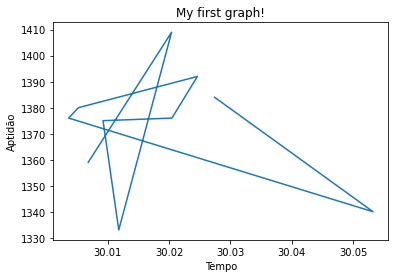

In [8]:
## tavel plotar alguns graficos

# importing the required module
import matplotlib.pyplot as plt
 
 
# plotting the points
plt.plot(grafico_1[0], grafico_1[1])
# plt.plot(grafico_2[2], grafico_2[1])
 
# naming the x axis
plt.xlabel('Tempo')
# naming the y axis
plt.ylabel('Aptidão')
 
# giving a title to my graph
plt.title('My first graph!')
 
# function to show the plot
plt.show()